# MODELLO PER PM
I modelli attuali hanno un mse di 144 in PM2.5 e RMSE 21.9 in PM10 (http://www.ec4macs.eu/content/report/EC4MACS_Publications/MR_Final%20in%20pdf/Chimere_Methodologies_Final.pdf) usano CHIMERE e NINFA

Il modello coi sensori diffusi non risente del downwash tra le case, capisce i microfenomeni usando la statistica.

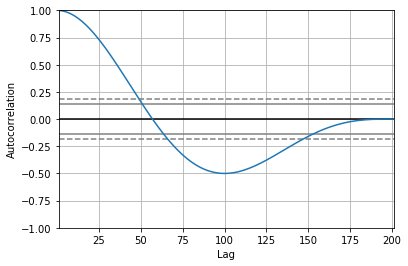

In [2]:
x = np.linspace(-np.pi, np.pi, 201)
autocorrelation_plot(pd.Series(np.sin(x)))

In [1]:
import datetime
import warnings

import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import scipy.stats as stats

In [2]:
# Nasconde i warning errati di pandas ma anche tutti gli altri, attenzione agli aggiornamenti di tensorflow
warnings.simplefilter("ignore")

In [3]:
style.use('bmh')
sns.set_style("ticks")
sns.set_style("darkgrid")
cmap = sns.diverging_palette(220, 20, as_cmap = True)

In [4]:
df_pm = pd.read_json("dati_milano/pm10_11_18.json")
df_temp = pd.read_json("dati_milano/temperature_11_18.json")
df_umi = pd.read_json("dati_milano/umidita_11_18.json")
df_prec = pd.read_json("dati_milano/precipitazioni_11_18.json")

In [5]:
#df = df_pm.shift(1)
df = df_pm
df["temp"] = df_temp
df["umi"] = df_umi
df["prec"] = df_prec
#df["weekend"] = (df.index.weekday > 4) * 1
df["weekday"] = df.index.weekday
df["mese"] = df.index.month

In [6]:
df = df.dropna()

In [7]:
df.head()

,pm10,temp,umi,prec,weekday,mese
2012-01-12,106,4.5,77.1,0.0,3,1
2012-01-13,88,4.9,78.4,0.0,4,1
2012-01-14,96,0.2,91.6,0.2,5,1
2012-01-15,87,-2.6,95.1,0.2,6,1
2012-01-16,97,-1.6,88.7,0.0,0,1


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pm10,2469.0,38.326043,24.450977,4.0,21.0,31.0,49.0,171.0
temp,2469.0,14.807250,8.246669,-6.6,7.7,15.0,21.7,32.1
umi,2469.0,69.719320,15.287999,15.7,58.0,69.8,81.8,100.0
prec,2469.0,2.971081,8.047349,0.0,0.0,0.0,1.0,119.8
weekday,2469.0,3.001215,2.000506,0.0,1.0,3.0,5.0,6.0
mese,2469.0,6.428514,3.395859,1.0,3.0,6.0,9.0,12.0


## Correlazioni:
Le correlazioni rivelano una relazione abbastanza forte tra i pm10 e la temperatura e l'umidità.
Sembra inoltre essere più rilevante il **_numero di giorni senza pioggia_** rispetto all'effettivo ammontare della pioggia.

In [9]:
df.corr()

,pm10,temp,umi,prec,weekday,mese
pm10,1.000000,-0.561905,0.371262,-0.183460,-0.002510,-0.020510
temp,-0.561905,1.000000,-0.511789,-0.067390,0.005361,0.205313
umi,0.371262,-0.511789,1.000000,0.347604,0.026695,0.159614
prec,-0.183460,-0.067390,0.347604,1.000000,0.027033,-0.004066
weekday,-0.002510,0.005361,0.026695,0.027033,1.000000,0.000579
mese,-0.020510,0.205313,0.159614,-0.004066,0.000579,1.000000


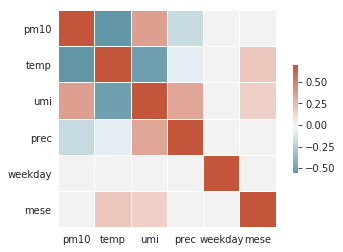

In [10]:
sns.heatmap(df.corr(), cmap = cmap, vmax = .7, center = 0,
            square = True, linewidths = .1, cbar_kws = {"shrink": .5})

Proof che la distribuzione dei valori di pm10 non è random, ed è possibile creare un modello valido:

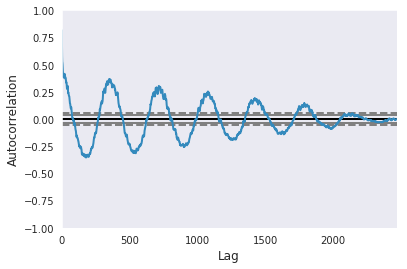

In [11]:
autocorrelation_plot(df.pm10)

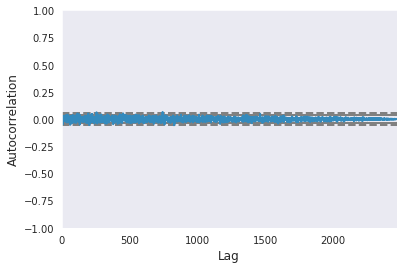

In [12]:
autocorrelation_plot(np.random.randint(df.pm10.max(), size=df.pm10.size))

## Dati ingegnerizzati

### Giorni senza pioggia

In [13]:
df["no_pioggia"] = df.prec
df.no_pioggia.loc[df.no_pioggia != 0] = -1
df.no_pioggia.loc[df.no_pioggia == 0] = 1
df.no_pioggia.loc[df.no_pioggia == -1] = 0

In [14]:
#Sottraggo al vettore con somma cumulata i giorni con valori ripetuti
somma = df.no_pioggia.cumsum()
correttore = somma.copy()
correttore.loc[~somma.duplicated()] = np.nan
correttore.iloc[0] = 0
correttore = correttore.fillna(method = "ffill")
df.no_pioggia = (somma - correttore).astype(int)

In [15]:
df.head()

,pm10,temp,umi,prec,weekday,mese,no_pioggia
2012-01-12,106,4.5,77.1,0.0,3,1,1
2012-01-13,88,4.9,78.4,0.0,4,1,2
2012-01-14,96,0.2,91.6,0.2,5,1,0
2012-01-15,87,-2.6,95.1,0.2,6,1,0
2012-01-16,97,-1.6,88.7,0.0,0,1,1


In [16]:
df.corr()

,pm10,temp,umi,prec,weekday,mese,no_pioggia
pm10,1.000000,-0.561905,0.371262,-0.183460,-0.002510,-0.020510,0.099256
temp,-0.561905,1.000000,-0.511789,-0.067390,0.005361,0.205313,0.279184
umi,0.371262,-0.511789,1.000000,0.347604,0.026695,0.159614,-0.428437
prec,-0.183460,-0.067390,0.347604,1.000000,0.027033,-0.004066,-0.257305
weekday,-0.002510,0.005361,0.026695,0.027033,1.000000,0.000579,0.011881
mese,-0.020510,0.205313,0.159614,-0.004066,0.000579,1.000000,-0.046716
no_pioggia,0.099256,0.279184,-0.428437,-0.257305,0.011881,-0.046716,1.000000


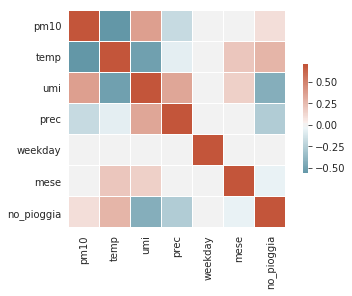

In [17]:
sns.heatmap(df.corr(), cmap = cmap, vmax = .7, center = 0,
            square = True, linewidths = .1, cbar_kws = {"shrink": .5})

## Studio valori notevoli

In [18]:
f"Massimo PM10: {df.pm10.max()} il {df.pm10.idxmax()}"

'Massimo PM10: 171 il 2017-01-31 00:00:00'

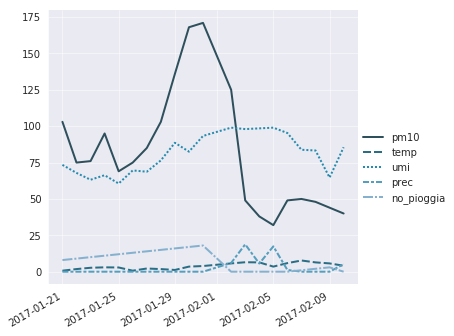

In [19]:
palette = sns.color_palette("PuBuGn_d", 5)

g = sns.relplot(kind="line",
                palette = palette,
                data = 
                df.loc[
                    df.pm10.idxmax() - datetime.timedelta(days=10) : 
                    df.pm10.idxmax() + datetime.timedelta(days=10)
                ].drop(["weekday", "mese"], axis = 1)
               )
g.fig.autofmt_xdate()

In [20]:
f"Minimo PM10: {df.pm10.min()} il {df.pm10.idxmin()}"

'Minimo PM10: 4 il 2012-07-22 00:00:00'

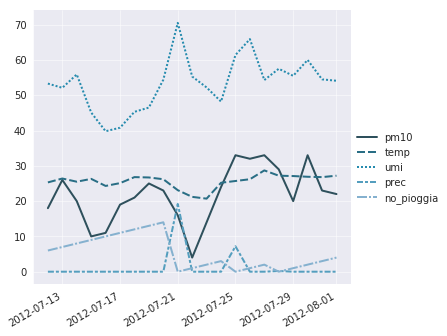

In [21]:
g = sns.relplot(kind="line",
                palette = palette,
                data = 
                df.loc[
                    df.pm10.idxmin() - datetime.timedelta(days=10) : 
                    df.pm10.idxmin() + datetime.timedelta(days=10)
                ].drop(["weekday", "mese"], axis = 1)
               )
g.fig.autofmt_xdate()

In [22]:
f"Il periodo più lungo senza pioggia è finito il {df.no_pioggia.idxmax()}, {df.no_pioggia.max()} giorni"

'Il periodo più lungo senza pioggia è finito il 2015-07-24 00:00:00, 31 giorni'

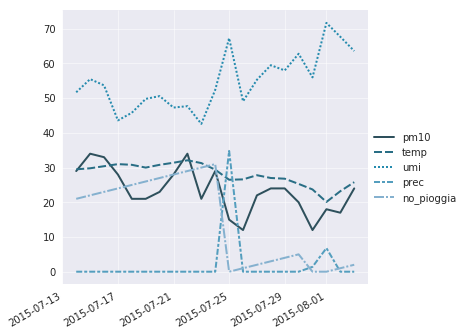

In [23]:
g = sns.relplot(kind="line",
                palette = palette,
                data = 
                df.loc[
                        df.no_pioggia.idxmax() - datetime.timedelta(days=10) : 
                        df.no_pioggia.idxmax() + datetime.timedelta(days=10)
                    ].drop(["weekday", "mese"], axis = 1)
               )
g.fig.autofmt_xdate()

# STATISTICA

In [24]:
studio = df.reset_index().pm10

## Normale

In [25]:
f"p-value della normale: {stats.shapiro(studio)[1]}"

'p-value della normale: 5.644430214300363e-42'

Rispetta decisamente la distribuzione normale.

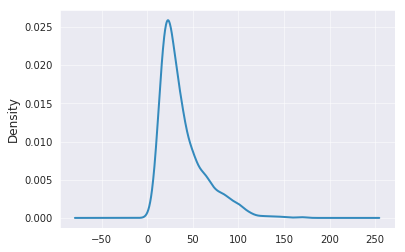

In [26]:
studio.plot.kde()

## Poisson

Risulta non essere in linea con la distribuzione di Poisson.

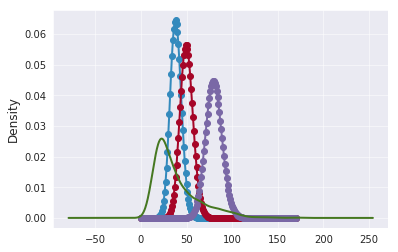

In [27]:
mu_params = [studio.mean(), 50, 80]
x = range(studio.max())
for mu in mu_params:
    y = stats.poisson(mu).pmf(x)
    plt.plot(x, y, 'o-', label=f'μ = {mu:3.1f}')
studio.plot.kde()

# CAPIRE SE UN VALORE E' FUORI SCALA

Utilizzando lo Z value e verificando se è maggiore di 2:

In [28]:
Z_values = (studio - studio.mean())/studio.std()

Seleziono i valori fuori dal 95% o 2 std:

In [29]:
studio[Z_values > 1.96].head(10)

0     106
1      88
2      96
3      87
4      97
5     106
6     146
7     141
11    116
25    107
Name: pm10, dtype: int64

In [38]:
f"Come previsto i valori sono il {studio[Z_values > 1.96].size / studio.size :.2%} del totale"

'Come previsto i valori sono il 5.79% del totale'

I valori fuori dal 99% o 3 std:

In [31]:
studio[Z_values > 3].head(10)

6      146
7      141
11     116
28     129
33     113
37     157
38     170
355    146
400    128
698    136
Name: pm10, dtype: int64

In [32]:
(studio[Z_values > 3] > 100).all()

True

In [33]:
f"I valori sono il {studio[Z_values > 3].size / studio.size :.2%} del totale"

'I valori sono il 1.26% del totale'

In [34]:
Z_values.var()

0.9999999999999997

In [35]:
Z_values

0       2.767740
1       2.031573
2       2.358759
3       1.990675
4       2.399657
5       2.767740
6       4.403667
7       4.199176
8       1.418101
9       0.886425
10      1.336305
11      3.176722
12      0.886425
13      0.518342
14      1.458999
15      0.968221
16      0.600138
17      0.068462
18      0.313851
19      0.272953
20      0.109360
21      0.109360
22      0.722832
23      1.499897
24      0.681934
25      2.808639
26      2.522351
27      2.276962
28      3.708398
29      0.968221
          ...   
2439    0.191156
2440    0.191156
2441   -0.258724
2442    0.232054
2443    0.681934
2444    0.641036
2445    0.313851
2446   -0.217825
2447    0.518342
2448    0.354749
2449    0.436545
2450    0.436545
2451    0.804629
2452    0.845527
2453    0.722832
2454    1.131814
2455    0.927323
2456   -0.831298
2457   -0.095131
2458   -0.790400
2459    0.968221
2460   -0.176927
2461   -0.708603
2462   -1.035789
2463   -1.035789
2464   -0.667705
2465   -0.872196
2466   -0.8721